<h1>Process & the ML Agenda</h1>

Process info from Monmouth University 2020 national poll

- courtesy of your mom

In [2]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

<h2>Rename Columns</h2>

In [3]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")

In [4]:
propensity = pd.read_csv("../data/output11.csv", index_col=0)
propensity

,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se
age_recoded,,,,,,
1,1,False,1,1,0.679457,0.080854
1,1,False,1,2,0.732036,0.082192
1,1,False,1,4,0.579128,0.077876
1,1,False,1,5,0.620041,0.121134
1,1,False,1,6,0.388438,0.072786
...,...,...,...,...,...,...
3,9,True,3,51,0.600421,0.116523
3,9,True,3,53,0.498659,0.119723
3,9,True,3,54,0.631852,0.113445


In [416]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6A', 'Q6B', 'Q6C',
       'Q6D', 'Q6E', 'Q6F', 'Q7', 'Q8', 'Q9', 'Q9A.1', 'Q9A.2', 'Q9A.3',
       'Q10A', 'Q10B', 'Q10C', 'Q10D', 'Q10E', 'Q10F', 'Q10G', 'QD1', 'Q11',
       'Q12', 'Q12B', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'QD2',
       'QD2A', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6', 'QD7', 'QD8', 'QD9', 'QD10',
       'QD11', 'FINALWGT'],
      dtype='object')

In [5]:
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})

# Big Function to encode columns

In [70]:
def recodeCols(df):

    cols = df.columns
    # vote choice
    if '12_2' not in cols:
        # for march 2020 data
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
    else:
        # for june 2020 data
        df['vote_choice'] = df.apply(lambda s: np.where(pd.isnull(s['12_1']), s['12_2'], s['12_1']), axis = 1)
      
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))
    # party recode
    df['party_recoded'] = df.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
    df['party_recoded'] = df['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

    # age recode
    df['age_recoded'] = df.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

    df['age_recoded'] = df['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, np.where(s >= 35 and s <= 54, 2.0, 3.0)))   

    # approval ratings 
    df['approve_trump'] = df['approve_trump'] == 1
    df['approve_biden'] = df['approve_biden'] == 1 

    # race, overwrite if hispanic/latino
    df['latino'] = df['latino'] == 1

    def recode_race(s):
        if s['latino'] == 1 or s['race'] == 4: 
            return 4
        elif s['race'] != 5 and s['race'] != 9:
            return s['race']
        else:
            return 9
    df['race_recoded'] = df.apply(recode_race, axis = 1)

    # gender => male = True, female = False
    df['male'] = df['gender'] == 1

    # registered to vote

    df['registered_vote'] = df['registered_vote'] == 1


    # True if they think Trump is focused on important issues, False otherwise
    if 'focused_imp_issues' in cols:
        df['focused_imp_issues'] = df['focused_imp_issues'] == 1

    # combine some of the similar household concern categories 
    if 'top_household_concern' in cols:
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

    # turn into 1 = no college, 3 = college
    def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
    df['education_recoded'] = df['education'].apply(recode_education)
    # combine into liberal, conservative, moderate, or other
    def recode_political_leaning(s):
        if s <= 2:
            return 1
        elif s == 4 or s == 9:
            return 2
        elif s == 3:
            return 3
        else:
            return 4
    df['political_leaning'] = df['political_leaning'].apply(recode_political_leaning)

    # Do you feel optimistic or pessimistic about the 2020 presidential election? 1 or 2 = optimistic of some sort, else pessimistic of some sort
    df['optimistic'] = df['optimistic'] <= 2

    # confidence in trump stamina to be president, under 2 is confident, over 2 is not confident
    if 'trump_stamina' in cols:
        df['trump_stamina'] = df['trump_stamina'] <= 2
    # confidence in biden stamina to be president, under 2 is confident, over 2 is not confident
    if 'biden_stamina' in cols:
        df['biden_stamina'] = df['biden_stamina'] <= 2
    ### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
    def recode_region(s):
        new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
        midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
        south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
        west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
        
        if s in new_england:
            return 1
        elif s in midwest:
            return 2 
        elif s in south:
            return 3
        elif s in west:
            return 4
        
    df['region'] = df['state'].apply(recode_region)

    # merge propensities
    df['age_recoded'] = df['age_recoded'].astype(int)
    df_result = pd.merge(df, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded', 'STATEFIP'], 
                        how='left')

    # Renaming the merged column for clarity
    df['propensity'] = df_result['mrp_subgroup_estimate']
    df = df.dropna(subset = ['vote_choice_recoded'], how = 'all')

    return df

In [7]:
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])

In [8]:
nat_2020['vote_choice'].value_counts()

vote_choice
2.0    358
1.0    320
8.0     39
6.0     21
9.0     12
7.0      3
Name: count, dtype: int64

In [9]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'top_household_concern', 'registered_vote',
       'likely_to_vote', 'vote_choice', 'vote_choice_undecided',
       'approve_trump', 'approve_biden', 'optimistic', 'elec_enthusiasm',
       'economic_situation', 'focused_imp_issues', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT'],
      dtype='object')

<h2>Recode Variables</h2>

<h3>Vote Choice</h3>

In [10]:
nat_2020['vote_choice_recoded'] = nat_2020.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020['vote_choice_recoded'] = nat_2020['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Party Leaning</h3>

In [11]:
nat_2020['party_recoded'] = nat_2020.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
nat_2020['party_recoded'] = nat_2020['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Age</h3>

Convert so they're all in bins

In [12]:
nat_2020['age_recoded'] = nat_2020.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

nat_2020['age_recoded'] = nat_2020['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, 
                                                        np.where(s >= 35 and s <= 54, 2.0, 3.0)))

<h3>Approval Ratings</h3>

In [13]:
nat_2020['approve_trump'] = nat_2020['approve_trump'] == 1
nat_2020['approve_biden'] = nat_2020['approve_biden'] == 1

<h3>Race</h3>

Overwrite if hispanic/latino

In [14]:
nat_2020['latino'] = nat_2020['latino'] == 1

In [15]:
def recode_race(s):
    if s['latino'] == 1 or s['race'] == 4: 
        return 4
    elif s['race'] != 5 and s['race'] != 9:
        return s['race']
    else:
        return 9

In [16]:
nat_2020['race_recoded'] = nat_2020.apply(recode_race, axis = 1)

<h3>Gender</h3>

In [17]:
nat_2020['male'] = nat_2020['gender'] == 1

In [18]:
# nat_2020.to_csv("../data/nat_2020_cleaned_no_dummies.csv", index = False)

In [19]:
nat_2020['registered_vote'].value_counts()

registered_vote
1    754
2     94
9      3
Name: count, dtype: int64

In [20]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
2    399
1    394
9     58
Name: count, dtype: int64

In [21]:
nat_2020['age_recoded'].value_counts()

age_recoded
3.0    357
2.0    304
1.0    190
Name: count, dtype: int64

In [22]:
nat_2020['economic_situation'].value_counts()

economic_situation
2    548
1    202
3     93
9      8
Name: count, dtype: int64

<h3>Registered to Vote</h3>

In [23]:
# True if they're registered to vote, false otherwise
nat_2020['registered_vote'] = nat_2020['registered_vote'] == 1

<h3>Focused on Important Issues</h3>

In [24]:
# True if they think Trump is focused on important issues, False otherwise
nat_2020['focused_imp_issues'] = nat_2020['focused_imp_issues'] == 1

In [25]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
False    457
True     394
Name: count, dtype: int64

<h3>Combine Concerns</h3>

In [26]:
# combine some of the similar household concern categories 
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

<h3>Education</h3>

In [27]:
# turn into no high school, some college or vocational, college or others 
def recode_education(s):
    if s <= 3:
        return 1
    # elif s > 4 and s <=6:
    #     return 2
    else:
        return 3
    # else:
    #     return 9

In [28]:
nat_2020['education_recoded'] = nat_2020['education'].apply(recode_education)

<h3>Political Leaning</h3>

In [29]:
# combine into liberal, conservative, moderate, or other
def recode_political_leaning(s):
    if s <= 2:
        return 1
    elif s == 4 or s == 9:
        return 2
    elif s == 3:
        return 3
    else:
        return 4

In [30]:
nat_2020['political_leaning'] = nat_2020['political_leaning'].apply(recode_political_leaning)

<h3>Optimistic</h3>

In [31]:
# true if optimistic about website, false otherwise
nat_2020['optimistic'] = nat_2020['optimistic'] <= 2

<h3>Region</h3>

In [32]:
### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
def recode_region(s):
    new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
    midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
    south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
    west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
    
    if s in new_england:
        return 1
    elif s in midwest:
        return 2 
    elif s in south:
        return 3
    elif s in west:
        return 4
    
    

In [33]:
nat_2020['region'] = nat_2020['state'].apply(recode_region)

### merge propensity to this

In [34]:
# prop_avg_values = propensity.groupby(['male', 'race_recoded', 'education_recoded', 'age_recoded'])['mean'].max().reset_index()
# prop_avg_values
# make age recoded into int
nat_2020['age_recoded'] = nat_2020['age_recoded'].astype(int)
df_result = pd.merge(nat_2020, propensity, 
                     on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                     how='left')

# Renaming the merged column for clarity
nat_2020['propensity'] = df_result['mrp_subgroup_estimate']
nat_2020

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,24.0,0.879980,3.0,1.0,2,1,True,3,3.0,0.662834
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,34.0,1.089499,1.0,3.0,1,1,True,3,1.0,0.717729
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,37.0,0.520273,1.0,1.0,3,1,True,3,3.0,0.559721
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,37.0,0.573839,2.0,2.0,3,1,False,3,3.0,0.602311
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,13.0,0.972234,1.0,1.0,2,9,False,3,3.0,0.367873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,26.0,0.469501,2.0,3.0,2,1,True,3,2.0,0.393554
847,3752,1,20.0,False,NaN,NaN,NaN,False,False,True,...,24.0,1.207679,NaN,2.0,1,1,False,3,3.0,0.557373
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,12.0,0.906539,3.0,2.0,3,1,False,3,3.0,0.521897
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,22.0,0.665262,2.0,2.0,2,2,False,3,3.0,0.672095


## Test Big function

In [135]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])
nat_2020['STATEFIP'] = nat_2020['state']
nat_2020 = recodeCols(nat_2020)
propensity2 = pd.read_csv('../data/output7.csv')
# merge null propensities with propensities from output 7
propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
nat_2020 = pd.merge(nat_2020, propensity2, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')
# if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# fill null with prop_small
nat_2020['propensity_fix'] = nat_2020['propensity'].fillna(nat_2020['prop_small'])
nat_2020
nat_2020_pre_dummies = nat_2020.copy()

In [73]:
nat_2020_pre_dummies

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,FINALWGT,STATEFIP,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,0.879980,24.0,3.0,1.0,2,1,True,3,3.0,0.321250
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,1.089499,34.0,1.0,3.0,1,1,True,3,1.0,0.408410
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,0.520273,37.0,1.0,1.0,3,1,True,3,3.0,0.522804
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,0.573839,37.0,2.0,2.0,3,1,False,3,3.0,0.437216
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,0.972234,13.0,1.0,1.0,2,9,False,3,3.0,0.530383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,3742,2,20.0,True,1.0,1.0,NaN,False,False,True,...,0.469501,26.0,1.0,1.0,2,1,True,3,2.0,0.526899
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,0.469501,26.0,2.0,3.0,2,1,True,3,2.0,0.526899
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,0.906539,12.0,3.0,2.0,3,1,False,3,3.0,0.455100
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,0.665262,22.0,2.0,2.0,2,2,False,3,3.0,0.111499


In [1022]:
# nat_2020_pre_dummies['race_recoded'].value_counts()

race_recoded
1    541
2     87
4     72
9     32
3     21
Name: count, dtype: int64

In [37]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")

nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8A',
       'Q8B', 'Q8C', 'Q9', 'Q10', 'Q10A', 'Q10B', 'QD1', 'Q11', 'Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'Q13A', 'Q13B', 'Q14', 'Q14A', 'Q15', 'Q16',
       'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
       'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q35A',
       'Q35B', 'QD2', 'QD2A', 'QD2B', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6',
       'QD7', 'QD8', 'QD9', 'QD10', 'QD11', 'FINALWGT'],
      dtype='object')

In [38]:
nat_2020_june[['Q12_1',
       'Q12_2']]
#merge the two vote choice columns
nat_2020_june['vote_choice'] = nat_2020_june.apply(lambda s: np.where(pd.isnull(s['Q12_1']), s['Q12_2'], s['Q12_1']), axis = 1)
# drop row if 'Q12_1', 'Q12_2', 'Q12A', 'Q12B' all are null

nat_2020_june = nat_2020_june.dropna(subset = ['Q12_1', 'Q12_2', 'Q12A', 'Q12B'], how = 'all')

nat_2020_june['vote_choice_recoded'] = nat_2020_june.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))

KeyError: 'vote_choice_undecided'

In [ ]:
nat_2020_june['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    405
1.0    289
3.0     38
Name: count, dtype: int64

In [ ]:
nat_2020_june[['Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'vote_choice', 'vote_choice_recoded']]

,Q12_1,Q12_2,Q12A,Q12B,vote_choice,vote_choice_recoded
0,2.0,NaN,1.0,NaN,2.0,2.0
1,NaN,2.0,1.0,NaN,2.0,2.0
2,2.0,NaN,1.0,NaN,2.0,2.0
5,NaN,2.0,1.0,NaN,2.0,2.0
6,NaN,2.0,2.0,NaN,2.0,2.0
...,...,...,...,...,...,...
862,6.0,NaN,2.0,1.0,6.0,1.0
863,NaN,1.0,1.0,NaN,1.0,1.0
864,1.0,NaN,1.0,NaN,1.0,1.0
865,2.0,NaN,1.0,NaN,2.0,2.0


In [136]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")
nat_2020_june = nat_2020_june.rename(columns = {
        # 'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12_1': '12_1',
        'Q12_2': '12_2',
        'Q12B': 'vote_choice_undecided', 
        'Q15': 'approve_trump',
        'Q16': 'approve_biden',
        'Q19': 'optimistic',
        'Q21': 'elec_enthusiasm',
        'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        'Q17': 'trump_stamina',
        'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_june = nat_2020_june.drop(columns = [c for c in nat_2020_june.columns if 'Q' in c])
nat_2020_june['STATEFIP'] = nat_2020_june['state']
nat_2020_june = recodeCols(nat_2020_june)
nat_2020_june.drop(columns=['12_1', '12_2', 'vote_choice', 'vote_choice_undecided'], inplace = True)
propensity2 = pd.read_csv('../data/output7.csv')
propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
nat_2020_june = pd.merge(nat_2020_june, propensity2, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')
# if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# fill null with prop_small
nat_2020_june['propensity_fix'] = nat_2020_june['propensity'].fillna(nat_2020_june['prop_small'])

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,STATE_NAME,state,e_votes,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML,State,2020_turnout,PERWT_state_scaled
1236,25,1,1,False,1,539643.0,0.002130,MA,25,606926,massachusetts,massachusetts,11.0,339975.090,0.522100,0.285714,0.454561,Massachusetts,66.3,225403.484670
1237,25,1,1,False,3,1790.0,0.000007,MA,25,606926,massachusetts,massachusetts,11.0,1127.700,0.379313,0.320000,0.362367,Massachusetts,66.3,747.665100
1238,25,1,1,True,1,537330.0,0.002121,MA,25,606926,massachusetts,massachusetts,11.0,319711.350,0.618587,0.562500,0.602562,Massachusetts,66.3,211968.625050
1239,25,1,1,True,3,3147.0,0.000012,MA,25,606926,massachusetts,massachusetts,11.0,1872.465,0.476054,0.380952,0.448882,Massachusetts,66.3,1241.444295
1240,25,1,2,False,1,64635.0,0.000255,MA,25,606926,massachusetts,massachusetts,11.0,40720.050,0.126652,0.012665,0.094084,Massachusetts,66.3,26997.393150
1241,25,1,2,False,3,564.0,0.000002,MA,25,606926,massachusetts,massachusetts,11.0,355.320,0.074871,0.007487,0.055618,Massachusetts,66.3,235.577160
1242,25,1,2,True,1,64427.0,0.000254,MA,25,606926,massachusetts,massachusetts,11.0,38334.065,0.176364,0.500000,0.268831,Massachusetts,66.3,25415.485095
1243,25,1,2,True,3,485.0,0.000002,MA,25,606926,massachusetts,massachusetts,11.0,288.575,0.107236,0.125000,0.112312,Massachusetts,66.3,191.325225
1244,25,1,3,False,1,77270.0,0.000305,MA,25,606926,massachusetts,massachusetts,11.0,48680.100,0.320523,0.320523,0.320523,Massachusetts,66.3,32274.906300
1245,25,1,3,False,3,491.0,0.000002,MA,25,606926,massachusetts,massachusetts,11.0,309.330,0.210896,0.021090,0.156665,Massachusetts,66.3,205.085790


In [37]:
nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'economic_situation', 'registered_vote',
       'likely_to_vote', 'approve_trump', 'approve_biden', 'trump_stamina',
       'biden_stamina', 'optimistic', 'elec_enthusiasm', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity'],
      dtype='object')

In [137]:
nat_2020_aug = pd.read_csv("../data/national_aug_2020/MUP222_NATL_archive_full.tab", sep = "\t")
nat_2020_aug = nat_2020_aug.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q13': 'likely_to_vote', 
        'Q14': 'vote_choice', 
        # 'Q14_1': '14_1',
        # 'Q14_2': '14_2',
        'Q14B': 'vote_choice_undecided', 
        'Q17': 'approve_trump',
        'Q18': 'approve_biden',
        'Q21': 'optimistic',
        'Q23': 'elec_enthusiasm',
        # 'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        # 'Q17': 'trump_stamina',
        # 'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_aug = nat_2020_aug.drop(columns = [c for c in nat_2020_aug.columns if 'Q' in c])
# nat_2020_aug.columns
nat_2020_aug['STATEFIP'] = nat_2020_aug['state']

nat_2020_aug = recodeCols(nat_2020_aug)
nat_2020_aug.columns
nat_2020_aug.drop(columns=['vote_choice', 'vote_choice_undecided'], inplace = True)
propensity2 = pd.read_csv('../data/output7.csv')
propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
nat_2020_aug = pd.merge(nat_2020_aug, propensity2, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')
# if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# fill null with prop_small
nat_2020_aug['propensity_fix'] = nat_2020_aug['propensity'].fillna(nat_2020_aug['prop_small'])

In [138]:
# pull up column focused_imp_issues_2
nat_2020_aug = nat_2020_aug[nat_2020_aug['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_aug = nat_2020_aug.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_aug['vote_choice_recoded'] = nat_2020_aug['vote_choice_recoded'].astype(int)
nat_2020_aug['vote_choice_recoded'] = nat_2020_aug['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

nat_2020_aug['vote_choice_recoded'].value_counts()
nat_2020_aug.to_csv("../data/nat_2020_aug_cleaned.csv", index = False)

<h2>Add Dummy Variables</h2>

In [139]:
# categoricals = ['top_household_concern', 'registered_vote', 'region',
#                 'likely_to_vote', 'vote_choice', 'vote_choice_undecided', 
#                 'elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded', 'economic_situation', 'education_recoded']

categoricals = ['top_household_concern', 'registered_vote', 'region','economic_situation','likely_to_vote', 'vote_choice', 'vote_choice_undecided', 'education_recoded','elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']
june_categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']

In [140]:
def dummyGrabber(df, cats):
    for category in cats:
        df[category] = df[category].astype('category')
    dummies = pd.get_dummies(df[cats])
    df = df[[c for c in df.columns if c not in cats]]
        
    df = pd.concat([df, dummies], axis = 1)
    
    return df

In [141]:
for category in categoricals:
    nat_2020[category] = nat_2020[category].astype('category')


# dummies = pd.get_dummies(nat_2020[categoricals], drop_first=True)
dummies = pd.get_dummies(nat_2020[categoricals])

In [142]:
dummies


,top_household_concern_1.0,top_household_concern_2.0,top_household_concern_3.0,top_household_concern_4.0,top_household_concern_5.0,top_household_concern_6.0,top_household_concern_8.0,top_household_concern_9.0,top_household_concern_10.0,top_household_concern_12.0,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
749,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
750,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
751,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False


In [143]:
nat_2020 = nat_2020[[c for c in nat_2020.columns if c not in categoricals]]


In [144]:
nat_2020_pre_dummies.columns

Index(['RESPID', 'PHTYPE', 'top_household_concern', 'registered_vote',
       'likely_to_vote', 'vote_choice', 'vote_choice_undecided',
       'approve_trump', 'approve_biden', 'optimistic', 'elec_enthusiasm',
       'economic_situation', 'focused_imp_issues', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity',
       'mrp_subgroup_estimate_se', 'prop_small', 'propensity_fix'],
      dtype='object')

In [145]:
nat_2020 = pd.concat([nat_2020, dummies], axis = 1)

In [146]:
nat_2020 = nat_2020[(nat_2020['vote_choice_recoded'] != 3.0) | 
                    (nat_2020['vote_choice_recoded'] != 7.0) |
                    (pd.isnull(nat_2020['vote_choice_recoded']) == False)]






In [147]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'male', 'propensity', 'mrp_subgroup_estimate_se',
       'prop_small', 'propensity_fix', 'top_household_concern_1.0',
       'top_household_concern_2.0', 'top_household_concern_3.0',
       'top_household_concern_4.0', 'top_household_concern_5.0',
       'top_household_concern_6.0', 'top_household_concern_8.0',
       'top_household_concern_9.0', 'top_household_concern_10.0',
       'top_household_concern_12.0', 'top_household_concern_13.0',
       'top_household_concern_14.0', 'top_household_concern_15.0',
       'top_household_concern_16.0', 'top_household_concern_17.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_

<h2>Train Test Split</h2>

In [86]:
nat_2020['vote_choice_recoded']
# 1 is trump, 2 is biden, 3 is other/undecided/none
nat_2020['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    381
1.0    334
3.0     38
Name: count, dtype: int64

In [87]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region

In [148]:
june_dummies = dummyGrabber(nat_2020_june, june_categoricals)

In [149]:
# june_dummies.columns
nat_2020_june_clean = june_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_june_clean

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,state,FINALWGT,STATEFIP,vote_choice_recoded,male,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,37,0.649035,37,2.0,False,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,36,0.585878,36,2.0,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,13,0.943746,13,2.0,False,...,True,False,False,False,False,True,False,False,True,False
3,False,False,False,True,False,42,1.355759,42,2.0,False,...,False,False,False,False,False,True,False,False,True,False
4,False,False,False,True,True,9,0.524317,9,2.0,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,False,False,True,False,True,34,1.084173,34,1.0,True,...,False,False,False,False,False,False,True,False,False,True
728,True,False,True,False,True,53,2.519819,53,1.0,True,...,False,True,False,False,True,False,False,False,True,False
729,True,False,True,False,True,6,0.864748,6,1.0,False,...,False,False,False,False,True,False,False,False,True,False
730,False,False,False,True,True,6,1.029771,6,2.0,False,...,False,False,False,False,False,True,False,False,False,True


In [150]:
nat_2020_june

,RESPID,PHTYPE,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,...,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity,mrp_subgroup_estimate_se,prop_small,propensity_fix
0,4,2,1,True,1.0,False,True,False,True,False,...,2.0,3,2,False,3,3,0.091761,0.031473,0.076863,0.091761
1,5,2,2,True,1.0,False,False,False,True,True,...,2.0,3,1,True,3,1,0.372418,0.040499,0.494095,0.372418
2,17,2,2,True,1.0,False,True,False,True,True,...,2.0,2,2,False,3,3,0.099644,0.032280,0.079057,0.099644
3,21,2,1,True,1.0,False,False,False,True,False,...,2.0,2,1,False,1,1,0.459437,0.063272,0.560710,0.459437
4,22,2,1,True,2.0,False,False,False,True,True,...,1.0,2,1,True,3,1,0.377077,0.040627,0.501755,0.377077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,20778,2,2,True,3.0,False,False,True,False,True,...,3.0,3,1,True,1,1,0.546773,0.053493,0.638314,0.546773
728,20786,1,2,True,1.0,True,False,True,False,True,...,1.0,2,3,True,3,4,0.261328,0.102036,0.299085,0.261328
729,20787,1,2,True,1.0,True,False,True,False,True,...,1.0,2,1,False,3,4,0.291949,0.039195,0.409255,0.291949
730,20789,1,2,True,1.0,False,False,False,True,True,...,2.0,3,1,False,3,4,0.291146,0.036011,0.401773,0.291146


## drop columns that made voter choice recoded column

In [151]:
nat_2020_clean = nat_2020.drop(columns=[
       'vote_choice_1.0','vote_choice_2.0', 'vote_choice_6.0',
       'vote_choice_7.0', 'vote_choice_8.0', 'vote_choice_9.0', 'vote_choice_undecided_1.0',
       'vote_choice_undecided_2.0', 'vote_choice_undecided_3.0',
       'vote_choice_undecided_9.0',
       'RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state'])

nat_2020_clean.columns

# keep or or drop FINALWGT?
# use state? income? education? -> not in data rn, keep in mind for future


# nat_2020_clean.to_csv('yeet.csv', index = False)

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'FINALWGT', 'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'mrp_subgroup_estimate_se', 'prop_small', 'propensity_fix',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 

In [152]:
# pull up column focused_imp_issues_2
nat_2020_june = nat_2020_june[nat_2020_june['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_june = nat_2020_june.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].astype(int)
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

nat_2020_june['vote_choice_recoded'].value_counts()

vote_choice_recoded
0    405
1    289
Name: count, dtype: int64

In [153]:
nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'economic_situation', 'registered_vote',
       'likely_to_vote', 'approve_trump', 'approve_biden', 'trump_stamina',
       'biden_stamina', 'optimistic', 'elec_enthusiasm', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity',
       'mrp_subgroup_estimate_se', 'prop_small', 'propensity_fix'],
      dtype='object')

In [154]:
def checkVoteRecode(df):
    df = df[df['vote_choice_recoded'] != 3.0]
    # change trump to be 1 and biden to be 0
    # biden originally encoded as 2 and trump as 1. 
    # drop if vote choice recorded is null
    df = df.dropna(subset = ['vote_choice_recoded'])
    # vote choice recoded to int
    df['vote_choice_recoded'] = df['vote_choice_recoded'].astype(int)
    df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))


    return df

In [155]:
propensity2 = pd.read_csv('../data/output7.csv')
# merge null propensities with propensities from output 7
propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
mar_prop_check = pd.merge(nat_2020_pre_dummies, propensity2, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')
# if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# fill null with prop_small
mar_prop_check['propensity_fix'] = mar_prop_check['propensity'].fillna(mar_prop_check['prop_small'])


KeyError: 'prop_small'

In [156]:
nat_2020_june_m = nat_2020_june[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
nat_2020_mar_m = nat_2020_pre_dummies[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
nat_2020_aug_m = nat_2020_aug[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
# pull up column focused_imp_issues_2
# nat_2020_mar_m = nat_2020_mar_m[nat_2020_mar_m['vote_choice_recoded'] != 3.0]
# # change trump to be 1 and biden to be 0
# # biden originally encoded as 2 and trump as 1. 
# # drop if vote choice recorded is null
# nat_2020_mar_m = nat_2020_mar_m.dropna(subset = ['vote_choice_recoded'])
# # vote choice recoded to int
# nat_2020_mar_m['vote_choice_recoded'] = nat_2020_mar_m['vote_choice_recoded'].astype(int)
# nat_2020_mar_m['vote_choice_recoded'] = nat_2020_mar_m['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))
nat_2020_june_m = checkVoteRecode(nat_2020_june_m)
nat_2020_aug_m = checkVoteRecode(nat_2020_aug_m)
nat_2020_mar_m = checkVoteRecode(nat_2020_mar_m)
nat_2020_mar_m['vote_choice_recoded'].value_counts()
combo_j_a_m = pd.concat([nat_2020_mar_m, nat_2020_june_m,nat_2020_aug_m]).reset_index(drop = True)
combo_j_a_m.dropna(subset = ['state'], inplace = True)
combo_j_a_m['state'] = combo_j_a_m['state'].astype(int)
combo_j_a_m.to_csv('../data/nat_2020_aug_june_mar.csv', index = False)

In [157]:
nat_2020_june.to_csv('../data/nat_2020_june_cleaned.csv', index = False)

In [158]:
# get propensity scores, use those as a column in the data, then train on data + that then 
nat_2020.loc[776].to_dict()

KeyError: 776

In [159]:
nat_2020_clean['vote_choice_recoded'].value_counts()
# if vote choice recorded is 7, make the value 3
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 7, 3, s))
nat_2020_clean['vote_choice_recoded'].isna().sum()

0

In [160]:
# (nat_2020_clean['vote_choice_recoded'] == 3.0).sum() sum of 3.0 answers is 38
# drop vote choice 3.0
nat_2020_clean = nat_2020_clean[nat_2020_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_clean = nat_2020_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].astype(int)
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [161]:
nat_2020_june_clean = nat_2020_june_clean[nat_2020_june_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_june_clean = nat_2020_june_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].astype(int)
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [162]:
nat_2020_june_clean.to_csv('june_vote_choice.csv', index = False)

In [163]:
nat_2020_clean['vote_choice_recoded'].value_counts().sum()

715

In [164]:
nat_2020_clean2= nat_2020_clean.drop(columns=['FINALWGT',  ])
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'mrp_subgroup_estimate_se', 'prop_small', 'propensity_fix',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_si

In [165]:
nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=['FINALWGT', 'state'])

In [166]:
nat_2020_june_clean2

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,STATEFIP,vote_choice_recoded,male,propensity,mrp_subgroup_estimate_se,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,37,0,False,0.091761,0.031473,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,36,0,True,0.372418,0.040499,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,13,0,False,0.099644,0.032280,...,True,False,False,False,False,True,False,False,True,False
3,False,False,False,True,False,42,0,False,0.459437,0.063272,...,False,False,False,False,False,True,False,False,True,False
4,False,False,False,True,True,9,0,True,0.377077,0.040627,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,False,False,True,False,True,34,1,True,0.546773,0.053493,...,False,False,False,False,False,False,True,False,False,True
728,True,False,True,False,True,53,1,True,0.261328,0.102036,...,False,True,False,False,True,False,False,False,True,False
729,True,False,True,False,True,6,1,False,0.291949,0.039195,...,False,False,False,False,True,False,False,False,True,False
730,False,False,False,True,True,6,0,False,0.291146,0.036011,...,False,False,False,False,False,True,False,False,False,True


In [167]:
# nat_2020_clean2['focused_imp_issues']

In [168]:
# X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded'])
# y = nat_2020_june_clean2['vote_choice_recoded']
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded'])
y = nat_2020_clean2['vote_choice_recoded']
# train test split
# TODO: consider stratifying by anything???? 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 13, stratify=X['male'])

In [984]:
y_test.value_counts()

vote_choice_recoded
0    185
1    173
Name: count, dtype: int64

In [985]:
y_train.value_counts()

vote_choice_recoded
0    196
1    161
Name: count, dtype: int64

In [169]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [170]:
models = [
  

    # ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
]

In [200]:
def modelFunc(X_train, y_train, X_test, y_test, data_dummies, models):
    best_f1 = 0
    for model in models:
    
        name = model[0]
        print(model[0])
        clf = model[1]
      
        grids =  GridSearchCV(clf, param_grid={}, scoring='f1_weighted' ,cv=5)
        grids.fit(X_train, y_train)
        y_preds = grids.best_estimator_.predict(X_test)
        if f1_score(y_test, y_preds, average='weighted') >= best_f1:
            new_model = grids.best_estimator_
        #print('train result', result['test_score'])
        grids.best_score_
        # print('mean_score:', -np.mean(result['test_score']))
        # y_preds = grids.best_estimator_.predict(X_test)

        print(f1_score(y_test, y_preds, average='weighted'))
    new_model.fit(X_train, y_train)
    y_preds = new_model.predict(X_test)
    X_test_copy = X_test.copy()
    X_test_copy['predicted_vote'] = y_preds
    X_test_copy['actual_vote'] = y_test
    X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_3', 'education_recoded_1']]

    filtered_nat_df = data_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'vote_choice_recoded', 'state'])
    filtered_nat_df['predicted_vote'] =     X_test_copy['predicted_vote']
    filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
    
    df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
    #filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
    return df_final_pred

In [172]:
propensity2 = pd.read_csv('../data/output7.csv')
# merge null propensities with propensities from output 7
propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
mar_prop_check = pd.merge(nat_2020_clean2, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')
mar_prop_check



KeyError: 'race_recoded'

In [188]:
nat_2020_clean2['propensity'] = nat_2020_clean2['propensity'].fillna(nat_2020_clean2['prop_small'])
nat_2020_pre_dummies['propensity'] = nat_2020_pre_dummies['propensity'].fillna(nat_2020_pre_dummies['prop_small'])

In [189]:
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'mrp_subgroup_estimate_se', 'prop_small', 'propensity_fix',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_si

In [190]:
nat_2020_clean2.loc[nat_2020_clean2.isnull()]

ValueError: Cannot index with multidimensional key

In [191]:
nat_2020_clean2

,approve_trump,approve_biden,optimistic,focused_imp_issues,STATEFIP,vote_choice_recoded,male,propensity,mrp_subgroup_estimate_se,prop_small,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
1,True,False,True,True,34.0,1,True,0.408410,0.050352,0.458959,...,False,False,False,False,False,False,True,True,False,False
2,True,False,True,True,37.0,1,True,0.522804,0.040499,0.494095,...,False,False,False,False,True,False,False,False,False,True
3,False,True,True,False,37.0,0,False,0.437216,0.036011,0.401773,...,False,False,False,False,False,True,False,False,False,True
4,False,True,False,True,13.0,1,False,0.530383,0.123004,0.486452,...,False,False,False,True,True,False,False,False,True,False
5,True,False,True,True,45.0,1,True,0.636107,0.040499,0.494095,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,True,False,True,True,39.0,1,False,0.471329,0.039195,0.409255,...,False,False,False,False,False,False,True,False,True,False
748,False,False,True,True,26.0,1,True,0.526899,0.040627,0.501755,...,False,False,False,False,True,False,False,False,True,False
749,False,False,False,False,26.0,0,True,0.526899,0.040627,0.501755,...,False,False,False,False,False,False,True,False,True,False
751,False,True,True,False,22.0,0,False,0.111499,0.032280,0.079057,...,True,False,False,False,False,True,False,False,True,False


In [197]:
nat_2020_clean2.dropna(inplace=True)

In [198]:
nat_2020_clean2

,approve_trump,approve_biden,optimistic,focused_imp_issues,STATEFIP,vote_choice_recoded,male,propensity,mrp_subgroup_estimate_se,prop_small,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
1,True,False,True,True,34.0,1,True,0.408410,0.050352,0.458959,...,False,False,False,False,False,False,True,True,False,False
2,True,False,True,True,37.0,1,True,0.522804,0.040499,0.494095,...,False,False,False,False,True,False,False,False,False,True
3,False,True,True,False,37.0,0,False,0.437216,0.036011,0.401773,...,False,False,False,False,False,True,False,False,False,True
4,False,True,False,True,13.0,1,False,0.530383,0.123004,0.486452,...,False,False,False,True,True,False,False,False,True,False
5,True,False,True,True,45.0,1,True,0.636107,0.040499,0.494095,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,True,False,True,True,39.0,1,False,0.471329,0.039195,0.409255,...,False,False,False,False,False,False,True,False,True,False
748,False,False,True,True,26.0,1,True,0.526899,0.040627,0.501755,...,False,False,False,False,True,False,False,False,True,False
749,False,False,False,False,26.0,0,True,0.526899,0.040627,0.501755,...,False,False,False,False,False,False,True,False,True,False
751,False,True,True,False,22.0,0,False,0.111499,0.032280,0.079057,...,True,False,False,False,False,True,False,False,True,False


In [201]:
nat_2020_clean2.notnull().sum()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'prop_small', 'propensity_fix'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 15)
mar_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded',])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 15)
june_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)

Random Forest Classification
0.9440203562340967
Random Forest Classification2
0.941503211506386
Gradient Boosting Classification
0.941503211506386
Gradient Boosting Classification2
0.9237097490914284
Gradient Boosting Classification3
0.9491259565804956
Random Forest Classification
0.9553865316407385
Random Forest Classification2
0.9500960034154058
Gradient Boosting Classification
0.9632443332156218
Gradient Boosting Classification2
0.9448429511433434
Gradient Boosting Classification3
0.9632443332156218


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_9405/2707198207.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)


In [202]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
mar_pred = pd.merge(all_combinations,mar_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
june_pred= pd.merge(all_combinations,june_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)
merge_mar_june['0'] = merge_mar_june['0_x'] + merge_mar_june['0_y']
# add 1_x and 1_y together
merge_mar_june['1'] = merge_mar_june['1_x'] + merge_mar_june['1_y']
# drop the _x and _y columns
merge_mar_june = merge_mar_june.drop(columns = ['0_x', '0_y', '1_x', '1_y'])

# add the propensity vibe column
merge_mar_june['propensity_t_pred'] = merge_mar_june['1'] / (merge_mar_june['0'] + merge_mar_june['1'])
merge_mar_june

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_9405/4119062865.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)


,age_recoded,race_recoded,male,education_recoded,0,1,propensity_t_pred
0,1,1,False,1,2.0,2.0,0.500000
1,1,1,False,3,22.0,9.0,0.290323
2,1,1,True,1,9.0,8.0,0.470588
3,1,1,True,3,30.0,19.0,0.387755
4,1,2,False,1,1.0,0.0,0.000000
5,1,2,False,3,2.0,0.0,0.000000
6,1,2,True,1,1.0,1.0,0.500000
7,1,2,True,3,8.0,1.0,0.111111
8,1,3,False,1,0.0,0.0,NaN
9,1,3,False,3,2.0,0.0,0.000000


In [980]:
models = [
  

    # ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'n_estimators': [100,150,200]}),

    # ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'n_neighbors': [3,5]}),
    # ("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [988]:
best_f1 = 0
for model in models:
  
    name = model[0]
    print(model[0])
    clf = model[1]
    # print(model[2])
    # pipe = Pipeline([('scaler', StandardScaler()), (name, clf)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(clf, param_grid={}, scoring='f1_weighted' ,cv=5)
    grids.fit(X_train, y_train)
   
    #print('train result', result['test_score'])
    grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_test)
    if f1_score(y_test, y_preds, average='weighted') >= best_f1:
        new_model = grids.best_estimator_

    print(f1_score(y_test, y_preds, average='weighted'))
    
    
   

Random Forest Classification
0.9329797297674395
Random Forest Classification2
0.9246016055975528
Gradient Boosting Classification
0.9273924439269251
Gradient Boosting Classification2
0.9246016094565876
Gradient Boosting Classification3
0.9441061251601405


In [989]:
logreg = LogisticRegression().fit(X_train, y_train)
y_preds_logreg = logreg.predict(X_test)
print(f1_score(y_test, y_preds_logreg, average='weighted'))
print(classification_report(y_test, y_preds_logreg))
# precision: how many did you guess right out of all the ones you guessed right for that class
# recall: how many did you guess right out of all the ones that were actually that class

0.9469319336987744
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       185
           1       0.94      0.95      0.95       173

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



0.9218072473059192
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       185
           1       0.91      0.93      0.92       173

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



<Axes: >

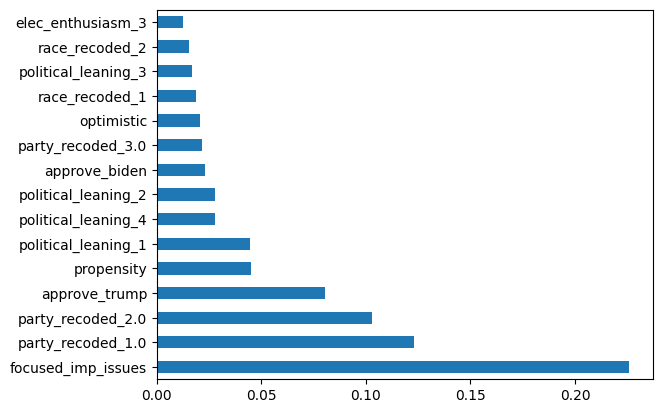

In [990]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_preds_rf = rf.predict(X_test)
print(f1_score(y_test, y_preds_rf, average='weighted'))
print(classification_report(y_test, y_preds_rf))
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# plt.figure(1)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [991]:
new_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.02, max_features=2, n_estimators=375,
                           random_state=0)>

In [992]:
new_model.fit(X_train, y_train)
y_preds = new_model.predict(X_test)
print(f1_score(y_test, y_preds, average='weighted'))
print(classification_report(y_test, y_preds))

0.9441061251601405
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       185
           1       0.95      0.93      0.94       173

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



In [993]:
y_test.to_numpy()

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,

In [994]:
y_preds

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,

In [995]:
# map preds back up to the original dataframe
nat_2020_clean_copy =nat_2020_clean2.copy()

In [998]:
X_test_copy = X_test.copy()
X_test_copy.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'male', 'propensity', 'top_household_concern_1.0',
       'top_household_concern_2.0', 'top_household_concern_3.0',
       'top_household_concern_4.0', 'top_household_concern_5.0',
       'top_household_concern_6.0', 'top_household_concern_8.0',
       'top_household_concern_9.0', 'top_household_concern_10.0',
       'top_household_concern_12.0', 'top_household_concern_13.0',
       'top_household_concern_14.0', 'top_household_concern_15.0',
       'top_household_concern_16.0', 'top_household_concern_17.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_True', 'region_1.0',
       'region_2.0', 'region_3.0', 'region_4.0', 'economic_situation_1',
       'economic_situation_2', 'economic_situation_3', 'economic_situation_9',
       'likely_to_vote_1.0', 'likely_to_vo

In [1055]:

X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
# X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','focused_imp_issues','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
#        'race_recoded_9', 'party_recoded_1.0',
#        'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3',
#        'vote_choice_recoded', 'actual_vote']]
X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_1', 'education_recoded_3']]

In [1056]:
# turn the dummies back into regular columns
X_test_copy_no_dummies = X_test_copy_filtered.copy()


In [1057]:
X_test_copy

,approve_trump,approve_biden,optimistic,focused_imp_issues,male,propensity,top_household_concern_1.0,top_household_concern_2.0,top_household_concern_3.0,top_household_concern_4.0,...,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3,predicted_vote,actual_vote
375,False,True,False,False,False,0.409255,True,False,False,False,...,False,False,False,True,False,False,True,False,0,NaN
819,True,False,True,False,False,0.148989,False,False,False,False,...,False,False,False,True,False,False,True,False,0,NaN
637,False,True,False,False,True,0.113641,False,False,False,False,...,False,False,False,True,False,False,True,False,0,NaN
19,True,False,True,True,True,0.429545,False,False,False,False,...,True,False,True,False,False,False,False,True,1,NaN
443,False,False,True,True,True,0.098313,False,False,False,False,...,False,False,True,False,False,True,False,False,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,True,False,False,True,False,0.401773,False,False,False,False,...,False,False,True,False,False,False,False,True,1,0.0
561,False,False,False,False,True,0.494095,False,False,False,False,...,False,False,False,False,True,False,False,True,0,NaN
4,False,True,False,True,False,0.486452,False,False,False,False,...,False,True,True,False,False,False,True,False,1,NaN
388,False,False,False,True,True,0.501755,False,False,False,False,...,False,False,True,False,False,False,True,False,1,NaN


In [1058]:
# filter the nat_2020_june with the indexes in X_test_copy_filtered

filtered_nat_2020_june = nat_2020_june.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020_june['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020_june['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020_june

KeyError: '[375, 637, 19, 62, 830, 59, 556, 772, 185, 452, 516, 597, 842, 518, 603, 317, 621, 686, 450, 433, 592, 736, 683, 691, 410, 9, 803, 800, 653, 832, 707, 583, 826, 715, 590, 400, 517, 825, 40, 843, 127, 26, 568, 268, 491, 376, 353, 512, 360, 193, 447, 275, 346, 276, 564, 692, 120, 413, 21, 507, 704, 430, 670, 205, 789, 310, 345, 506, 700, 757, 730, 220, 422, 235, 579, 585, 587, 208, 633, 763, 231, 505, 15, 364, 676, 473, 4, 388] not in index'

In [1060]:
filtered_nat_2020_june.groupby(['age_recoded','race_recoded',  'male', 'education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   4   2
                               3                   9   4
                         True  1                   3   4
                               3                  13   9
            2            False 1                   1   0
                               3                   1   0
                         True  1                   2   2
                               3                   4   0
            3            False 3                   1   0
                         True  3                   1   0
            4            False 3                   3   1
                         True  1                   1   0
                               3                   5   1
2           1            False 1                   4   6
                               3                  27  14
                         True  1                   1   7
                               3                  18  15
            2            False 1                   1   0
                               3                   8   0
                         True  1                   1   0
                               3                   8   2
            3            False 3                   1   0
                         True  3                   2   0
            4            False 3                   4   1
                         True  1                   0   1
                               3                   4   2
            9            False 3                   1   0
                         True  3                   1   0
3           1            False 1                   4   9
                               3                  25  25
                         True  1                   4   8
                               3                  21  19
            2            False 1                   1   1
                               3                  11   0
                         True  1                   4   0
                               3                   2   0
            3            False 3                   2   0
                         True  3                   2   0
            4            False 1                   1   0
                               3                   2   1
                         True  3                   0   3
            9            False 3                   1   0
                         True  3                   0   1

In [1066]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
pd.merge(all_combinations, filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0), on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')


,age_recoded,race_recoded,male,education_recoded,0,1
0,1,1,False,1,4.0,2.0
1,1,1,False,3,9.0,4.0
2,1,1,True,1,3.0,4.0
3,1,1,True,3,13.0,9.0
4,1,2,False,1,1.0,0.0
5,1,2,False,3,1.0,0.0
6,1,2,True,1,2.0,2.0
7,1,2,True,3,4.0,0.0
8,1,3,False,1,NaN,NaN
9,1,3,False,3,1.0,0.0


In [1062]:
june_final = filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=True)['predicted_vote'].value_counts().unstack(fill_value=0)

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   4   2
                               3                   9   4
                         True  1                   3   4
                               3                  13   9
            2            False 1                   1   0
                               3                   1   0
                         True  1                   2   2
                               3                   4   0
            3            False 3                   1   0
                         True  3                   1   0
            4            False 3                   3   1
                         True  1                   1   0
                               3                   5   1
2           1            False 1                   4   6
                               3                  27  14
                         True  1                   1   7
                               3                  18  15
            2            False 1                   1   0
                               3                   8   0
                         True  1                   1   0
                               3                   8   2
            3            False 3                   1   0
                         True  3                   2   0
            4            False 3                   4   1
                         True  1                   0   1
                               3                   4   2
            9            False 3                   1   0
                         True  3                   1   0
3           1            False 1                   4   9
                               3                  25  25
                         True  1                   4   8
                               3                  21  19
            2            False 1                   1   1
                               3                  11   0
                         True  1                   4   0
                               3                   2   0
            3            False 3                   2   0
                         True  3                   2   0
            4            False 1                   1   0
                               3                   2   1
                         True  3                   0   3
            9            False 3                   1   0
                         True  3                   0   1

In [144]:
nat_2020

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,24.0,0.879980,3.0,1.0,2,1,True,3,3.0,0.670994
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,34.0,1.089499,1.0,3.0,1,1,True,3,1.0,0.527561
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,37.0,0.520273,1.0,1.0,3,1,True,3,3.0,0.662109
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,37.0,0.573839,2.0,2.0,3,1,False,3,3.0,0.662109
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,13.0,0.972234,1.0,1.0,2,9,False,3,3.0,0.471235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,3742,2,20.0,True,1.0,1.0,NaN,False,False,True,...,26.0,0.469501,1.0,1.0,2,1,True,3,2.0,0.670994
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,26.0,0.469501,2.0,3.0,2,1,True,3,2.0,0.670994
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,12.0,0.906539,3.0,2.0,3,1,False,3,3.0,0.662109
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,22.0,0.665262,2.0,2.0,2,2,False,3,3.0,0.166517


In [491]:
nat_2020_pre_dummies

,RESPID,PHTYPE,approve_trump,approve_biden,optimistic,focused_imp_issues,party,party_unaffiliated,education,age,age_bin,latino,race,gender,state,FINALWGT,vote_choice_recoded,male,propensity
0,11,2,False,False,True,True,9,1.0,5,53,NaN,False,1,1,24.0,0.879980,3.0,True,0.501755
1,14,2,True,False,True,True,3,1.0,5,28,NaN,False,1,1,34.0,1.089499,1.0,True,0.458959
2,19,2,True,False,True,True,1,NaN,7,75,NaN,False,1,1,37.0,0.520273,1.0,True,0.494095
3,30,2,False,True,True,False,2,NaN,7,63,NaN,False,1,2,37.0,0.573839,2.0,False,0.401773
4,43,2,False,True,False,True,4,1.0,7,47,NaN,False,5,2,13.0,0.972234,1.0,False,0.486452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,3742,2,False,False,True,True,4,1.0,7,36,NaN,False,1,1,26.0,0.469501,1.0,True,0.501755
846,3746,1,False,False,False,False,3,2.0,7,51,NaN,False,1,1,26.0,0.469501,2.0,True,0.501755
848,3754,2,True,True,True,True,2,NaN,6,99,9.0,False,1,2,12.0,0.906539,3.0,False,0.401773
849,3762,1,False,True,True,False,2,NaN,7,49,NaN,False,2,2,22.0,0.665262,2.0,False,0.079057


In [1046]:

filtered_nat_2020 = nat_2020_pre_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020
march_final = filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
# merge with just the

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   1   1
                               3                  11   5
                         True  1                   4   4
                               3                  15   9
            2            False 3                   1   0
                         True  3                   3   1
            3            False 3                   2   0
                         True  3                   3   0
            4            False 1                   1   0
                               3                   1   1
                         True  1                   0   1
                               3                   2   2
            9            False 1                   1   0
                         True  3                   1   0
2           1            False 1                   1   4
                               3                  22  24
                         True  1                   1   9
                               3                  14  22
            2            False 1                   1   0
                               3                   8   0
                         True  3                   8   1
            3            False 3                   2   0
                         True  3                   1   1
            4            False 3                   2   4
                         True  3                   2   3
            9            False 3                   2   1
                         True  3                   2   2
3           1            False 1                   6  11
                               3                  23  23
                         True  1                   1  10
                               3                  13  23
            2            False 1                   5   0
                               3                  13   0
                         True  1                   1   1
                               3                   4   0
            3            False 1                   1   0
                               3                   1   0
            4            False 1                   1   0
                               3                   1   2
                         True  1                   2   1
                               3                   2   3
            9            False 1                   1   0
                               3                   1   0
                         True  3                   1   0

In [1045]:
merged_df = pd.merge(march_final, june_final, on=['age_recoded',	'race_recoded',	'male',	'education_recoded'], how='outer').fillna(0)
merged_df

predicted_vote                                     0_x   1_x   0_y   1_y
age_recoded race_recoded male  education_recoded                        
1           1            False 1                   1.0   1.0   4.0   2.0
                               3                  11.0   5.0   9.0   4.0
                         True  1                   4.0   4.0   3.0   4.0
                               3                  15.0   9.0  13.0   9.0
            2            False 1                   0.0   0.0   1.0   0.0
                               3                   1.0   0.0   1.0   0.0
                         True  1                   0.0   0.0   2.0   2.0
                               3                   3.0   1.0   4.0   0.0
            3            False 3                   2.0   0.0   1.0   0.0
                         True  3                   3.0   0.0   1.0   0.0
            4            False 1                   1.0   0.0   0.0   0.0
                               3                   1.0   1.0   3.0   1.0
                         True  1                   0.0   1.0   1.0   0.0
                               3                   2.0   2.0   5.0   1.0
            9            False 1                   1.0   0.0   0.0   0.0
                         True  3                   1.0   0.0   0.0   0.0
2           1            False 1                   1.0   4.0   4.0   6.0
                               3                  22.0  24.0  27.0  14.0
                         True  1                   1.0   9.0   1.0   7.0
                               3                  14.0  22.0  18.0  15.0
            2            False 1                   1.0   0.0   1.0   0.0
                               3                   8.0   0.0   8.0   0.0
                         True  1                   0.0   0.0   1.0   0.0
                               3                   8.0   1.0   8.0   2.0
            3            False 3                   2.0   0.0   1.0   0.0
                         True  3                   1.0   1.0   2.0   0.0
            4            False 3                   2.0   4.0   4.0   1.0
                         True  1                   0.0   0.0   0.0   1.0
                               3                   2.0   3.0   4.0   2.0
            9            False 3                   2.0   1.0   1.0   0.0
                         True  3                   2.0   2.0   1.0   0.0
3           1            False 1                   6.0  11.0   4.0   9.0
                               3                  23.0  23.0  25.0  25.0
                         True  1                   1.0  10.0   4.0   8.0
                               3                  13.0  23.0  21.0  19.0
            2            False 1                   5.0   0.0   1.0   1.0
                               3                  13.0   0.0  11.0   0.0
                         True  1                   1.0   1.0   4.0   0.0
                               3                   4.0   0.0   2.0   0.0
            3            False 1                   1.0   0.0   0.0   0.0
                               3                   1.0   0.0   2.0   0.0
                         True  3                   0.0   0.0   2.0   0.0
            4            False 1                   1.0   0.0   1.0   0.0
                               3                   1.0   2.0   2.0   1.0
                         True  1                   2.0   1.0   0.0   0.0
                               3                   2.0   3.0   0.0   3.0
            9            False 1                   1.0   0.0   0.0   0.0
                               3                   1.0   0.0   1.0   0.0
                         True  3                   1.0   0.0   0.0   1.0

In [1044]:
# filtered_nat_2020 and filtered_nat_2020_june merge on the same columns
filtered_nat_2020_june.columns
merged_df = pd.merge(march_final, june_final, on=['age_recoded',	'race_recoded',	'male',	'education_recoded'], how='outer').fillna(0)
# add 0_x and 0_y together
merged_df['0'] = merged_df['0_x'] + merged_df['0_y']
# add 1_x and 1_y together
merged_df['1'] = merged_df['1_x'] + merged_df['1_y']
# drop the _x and _y columns
merged_df = merged_df.drop(columns = ['0_x', '0_y', '1_x', '1_y'])
merged_df
# add the propensity vibe column
merged_df['propensity_t_pred'] = merged_df['1'] / (merged_df['0'] + merged_df['1'])
merged_df

predicted_vote                                       0     1  \
age_recoded race_recoded male  education_recoded               
1           1            False 1                   5.0   3.0   
                               3                  20.0   9.0   
                         True  1                   7.0   8.0   
                               3                  28.0  18.0   
            2            False 1                   1.0   0.0   
                               3                   2.0   0.0   
                         True  1                   2.0   2.0   
                               3                   7.0   1.0   
            3            False 3                   3.0   0.0   
                         True  3                   4.0   0.0   
            4            False 1                   1.0   0.0   
                               3                   4.0   2.0   
                         True  1                   1.0   1.0   
                               3                   7.0   3.0   
            9            False 1                   1.0   0.0   
                         True  3                   1.0   0.0   
2           1            False 1                   5.0  10.0   
                               3                  49.0  38.0   
                         True  1                   2.0  16.0   
                               3                  32.0  37.0   
            2            False 1                   2.0   0.0   
                               3                  16.0   0.0   
                         True  1                   1.0   0.0   
                               3                  16.0   3.0   
            3            False 3                   3.0   0.0   
                         True  3                   3.0   1.0   
            4            False 3                   6.0   5.0   
                         True  1                   0.0   1.0   
                               3                   6.0   5.0   
            9            False 3                   3.0   1.0   
                         True  3                   3.0   2.0   
3           1            False 1                  10.0  20.0   
                               3                  48.0  48.0   
                         True  1                   5.0  18.0   
                               3                  34.0  42.0   
            2            False 1                   6.0   1.0   
                               3                  24.0   0.0   
                         True  1                   5.0   1.0   
                               3                   6.0   0.0   
            3            False 1                   1.0   0.0   
                               3                   3.0   0.0   
                         True  3                   2.0   0.0   
            4            False 1                   2.0   0.0   
                               3                   3.0   3.0   
                         True  1                   2.0   1.0   
                               3                   2.0   6.0   
            9            False 1                   1.0   0.0   
                               3                   2.0   0.0   
                         True  3                   1.0   1.0   

predicted_vote                                    propensity_t_pred  
age_recoded race_recoded male  education_recoded                     
1           1            False 1                           0.375000  
                               3                           0.310345  
                         True  1                           0.533333  
                               3                           0.391304  
            2            False 1                           0.000000  
                               3                           0.000000  
                         True  1                           0.500000  
                               3                           0.125000  
            3            False 3   

In [ ]:
# TODO: make function/pipeline that can take in multiple custom datasets to build bigger propensity changer. Then you could use that to continue to cook with new stuff? do more monmouth? maybe 2 more of those plus whatever else we have?

# TODO: Aggregate the propensities from ML and MRP and see if they're similar ish. Then use that to make a new propensity score.

# TODO: with updated propensity score and Census People data from haley, ("../data/census/cleaned/post_stratification_data.csv") multiply by the amount of people in each category and then see if it's predicting the election right on a high level. See if You can find a way to weight the ML scores down to not make it change much. See if certain groups don't show as much. -> use turnout weights to bonk the numbers down to be more realistic?

# TODO: simulate running the ML a bunch of times to get more predictions? like oversample??? OOOOH SMOte LOL

# TODO: include people we dropped for 3rd party purposes? no validation fs but will bump average numbers based on how model predicts

In [203]:
propensity = pd.read_csv("../data/output7.csv")
post_strat = pd.read_csv("../data/post_stratification_data.csv")
post_strat = post_strat.drop(columns = ['prop'])
# propensity = propensity.drop(columns = ['mrp_subgroup_estimate_se'])
propensity_strat = pd.merge(propensity, post_strat)
propensity_strat
merged_df = merge_mar_june.copy()

In [204]:
propensity = pd.read_csv("../data/output7.csv") 
# 7 is best so far
# propensity = pd.read_csv("../data/output10.csv")
post_strat = pd.read_csv("../data/post_stratification_data.csv")
post_strat = post_strat.drop(columns = ['prop'])
# propensity = propensity.drop(columns = ['mrp_subgroup_estimate_se'])
propensity_strat = pd.merge(propensity, post_strat)
# multiply by 0.595 if male, 0.63 if female

propensity_strat['PERWT_scaled'] = propensity_strat.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)



multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
propensity_strat['PERWT_scaled'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

propensity_strat['PERWT_scaled_age'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)

# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
#     lambda row: row['PERWT'] * 0.698 if row['race_recoded'] == 1 elif row['PERWT'] * 0.698 if row['race_recoded'] == 1 else row['PERWT'] * 0.63, axis=1
# )
propensity_strat['trumpVote'] = propensity_strat['mrp_subgroup_estimate'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote'] = (1 - propensity_strat['mrp_subgroup_estimate']) * propensity_strat['PERWT_scaled']
propensity_strat
print('trump percent', propensity_strat['trumpVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'trumpSum', propensity_strat['trumpVote'].sum())
print('biden percent', propensity_strat['bidenVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'bidenSum', propensity_strat['bidenVote'].sum())
propensity_strat

trump percent 0.514642681641195 trumpSum 68784120.16999649
biden percent 0.4853573183588051 bidenSum 64870010.4020035


,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,PERWT_scaled,PERWT_scaled_age,trumpVote,bidenVote
0,1,1,False,1,0.533422,0.069685,20085870.0,1.154938e+07,1.104723e+07,6.160691e+06,5.388685e+06
1,1,1,False,3,0.368926,0.049127,92802.0,5.336115e+04,5.104110e+04,1.968631e+04,3.367484e+04
2,1,1,True,1,0.623275,0.064938,20914205.0,1.202567e+07,1.150281e+07,7.495302e+06,4.530366e+06
3,1,1,True,3,0.458959,0.050352,118666.0,6.823295e+04,6.526630e+04,3.131615e+04,3.691680e+04
4,1,2,False,1,0.136100,0.062747,5195904.0,2.670695e+06,2.857747e+06,3.634815e+05,2.307213e+06
5,1,2,False,3,0.068083,0.029945,44237.0,2.273782e+04,2.433035e+04,1.548053e+03,2.118977e+04
6,1,2,True,1,0.187976,0.076783,5152464.0,2.648366e+06,2.833855e+06,4.978300e+05,2.150537e+06
7,1,2,True,3,0.098313,0.041672,52348.0,2.690687e+04,2.879140e+04,2.645303e+03,2.426157e+04
8,1,3,False,1,0.343969,0.177622,2416194.0,9.761424e+05,1.328907e+06,3.357626e+05,6.403798e+05
9,1,3,False,3,0.210216,0.085995,30033.0,1.213333e+04,1.651815e+04,2.550616e+03,9.582716e+03


In [205]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,PERWT_scaled,PERWT_scaled_age,trumpVote,bidenVote
0,1,1,False,1,0.533422,0.069685,20085870.0,1.154938e+07,1.104723e+07,6.160691e+06,5.388685e+06
1,1,1,False,3,0.368926,0.049127,92802.0,5.336115e+04,5.104110e+04,1.968631e+04,3.367484e+04
2,1,1,True,1,0.623275,0.064938,20914205.0,1.202567e+07,1.150281e+07,7.495302e+06,4.530366e+06
3,1,1,True,3,0.458959,0.050352,118666.0,6.823295e+04,6.526630e+04,3.131615e+04,3.691680e+04
4,1,2,False,1,0.136100,0.062747,5195904.0,2.670695e+06,2.857747e+06,3.634815e+05,2.307213e+06
5,1,2,False,3,0.068083,0.029945,44237.0,2.273782e+04,2.433035e+04,1.548053e+03,2.118977e+04
6,1,2,True,1,0.187976,0.076783,5152464.0,2.648366e+06,2.833855e+06,4.978300e+05,2.150537e+06
7,1,2,True,3,0.098313,0.041672,52348.0,2.690687e+04,2.879140e+04,2.645303e+03,2.426157e+04
8,1,3,False,1,0.343969,0.177622,2416194.0,9.761424e+05,1.328907e+06,3.357626e+05,6.403798e+05
9,1,3,False,3,0.210216,0.085995,30033.0,1.213333e+04,1.651815e+04,2.550616e+03,9.582716e+03


In [206]:
merged_df['propensity_t_pred'].values

array([0.5       , 0.29032258, 0.47058824, 0.3877551 , 0.        ,
       0.        , 0.5       , 0.11111111,        nan, 0.        ,
              nan, 0.        , 0.        , 0.2       , 0.5       ,
       0.33333333,        nan, 0.5       , 1.        , 0.        ,
       0.53333333, 0.42045455, 0.85      , 0.53333333, 0.        ,
       0.        , 0.        , 0.2       ,        nan, 0.33333333,
              nan, 0.25      ,        nan, 0.6       , 0.66666667,
       0.35714286, 1.        , 0.33333333, 1.        , 0.57142857,
       0.6969697 , 0.53043478, 0.65384615, 0.57333333, 0.        ,
       0.04      , 0.        , 0.        , 0.        , 0.2       ,
              nan, 1.        , 0.        , 0.42857143, 1.        ,
       0.55555556, 1.        , 0.6       ,        nan, 0.25      ])

In [207]:
propensity_strat['ML_pred'] = merged_df['propensity_t_pred'].values
# fill with the originall propensity score if 0
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])

In [208]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,PERWT_scaled,PERWT_scaled_age,trumpVote,bidenVote,ML_pred
0,1,1,False,1,0.533422,0.069685,20085870.0,1.154938e+07,1.104723e+07,6.160691e+06,5.388685e+06,0.500000
1,1,1,False,3,0.368926,0.049127,92802.0,5.336115e+04,5.104110e+04,1.968631e+04,3.367484e+04,0.290323
2,1,1,True,1,0.623275,0.064938,20914205.0,1.202567e+07,1.150281e+07,7.495302e+06,4.530366e+06,0.470588
3,1,1,True,3,0.458959,0.050352,118666.0,6.823295e+04,6.526630e+04,3.131615e+04,3.691680e+04,0.387755
4,1,2,False,1,0.136100,0.062747,5195904.0,2.670695e+06,2.857747e+06,3.634815e+05,2.307213e+06,0.000000
5,1,2,False,3,0.068083,0.029945,44237.0,2.273782e+04,2.433035e+04,1.548053e+03,2.118977e+04,0.000000
6,1,2,True,1,0.187976,0.076783,5152464.0,2.648366e+06,2.833855e+06,4.978300e+05,2.150537e+06,0.500000
7,1,2,True,3,0.098313,0.041672,52348.0,2.690687e+04,2.879140e+04,2.645303e+03,2.426157e+04,0.111111
8,1,3,False,1,0.343969,0.177622,2416194.0,9.761424e+05,1.328907e+06,3.357626e+05,6.403798e+05,0.343969
9,1,3,False,3,0.210216,0.085995,30033.0,1.213333e+04,1.651815e+04,2.550616e+03,9.582716e+03,0.000000


In [209]:
propensity_strat['newcol'] = propensity_strat.apply(
    lambda row: row['ML_pred'] if row['ML_pred'] != 0 else row['mrp_subgroup_estimate'] / 2, axis=1
)

# .apply(lambda s: s if s != 0 else propensity_strat['mrp_subgroup_estimate'] / 2)


In [210]:
# propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 2

In [227]:
propensity_strat['ML_pred'] = merged_df['propensity_t_pred'].values
# fill with the originall propensity score if 0
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# if ML pred is 0, fill with MRP pred / 2

propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 10
propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = 1 - (propensity_strat['mrp_subgroup_estimate'] / 2 )

#weight the mrp and ml predictions by the PERWT_scaled
propensity_strat['mrp_and_ML'] = ((propensity_strat['mrp_subgroup_estimate'] * 10) + propensity_strat['ML_pred']) / 11
propensity_strat
propensity_strat['trumpVote_altered'] = propensity_strat['mrp_and_ML'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote_altered'] = (1 - propensity_strat['mrp_and_ML']) * propensity_strat['PERWT_scaled']
print('trump sum', propensity_strat['trumpVote_altered'].sum(), 'biden sum', propensity_strat['bidenVote_altered'].sum())
print('trump percent', propensity_strat['trumpVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))
print('biden percent', propensity_strat['bidenVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))

trump sum 68945647.49353038 biden sum 64708483.07846963
trump percent 0.5158512288281961
biden percent 0.4841487711718039


In [228]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,PERWT_scaled,PERWT_scaled_age,trumpVote,bidenVote,ML_pred,newcol,mrp_and_ML,trumpVote_altered,bidenVote_altered
0,1,1,False,1,0.533422,0.069685,20085870.0,1.154938e+07,1.104723e+07,6.160691e+06,5.388685e+06,0.500000,0.500000,0.530384,6.125599e+06,5.423776e+06
1,1,1,False,3,0.368926,0.049127,92802.0,5.336115e+04,5.104110e+04,1.968631e+04,3.367484e+04,0.290323,0.290323,0.361780,1.930501e+04,3.405614e+04
2,1,1,True,1,0.623275,0.064938,20914205.0,1.202567e+07,1.150281e+07,7.495302e+06,4.530366e+06,0.470588,0.470588,0.609395,7.328378e+06,4.697290e+06
3,1,1,True,3,0.458959,0.050352,118666.0,6.823295e+04,6.526630e+04,3.131615e+04,3.691680e+04,0.387755,0.387755,0.452486,3.087447e+04,3.735848e+04
4,1,2,False,1,0.136100,0.062747,5195904.0,2.670695e+06,2.857747e+06,3.634815e+05,2.307213e+06,0.013610,0.068050,0.124965,3.337421e+05,2.336953e+06
5,1,2,False,3,0.068083,0.029945,44237.0,2.273782e+04,2.433035e+04,1.548053e+03,2.118977e+04,0.006808,0.034041,0.062512,1.421394e+03,2.131642e+04
6,1,2,True,1,0.187976,0.076783,5152464.0,2.648366e+06,2.833855e+06,4.978300e+05,2.150537e+06,0.500000,0.500000,0.216342,5.729530e+05,2.075413e+06
7,1,2,True,3,0.098313,0.041672,52348.0,2.690687e+04,2.879140e+04,2.645303e+03,2.426157e+04,0.111111,0.111111,0.099477,2.676607e+03,2.423026e+04
8,1,3,False,1,0.343969,0.177622,2416194.0,9.761424e+05,1.328907e+06,3.357626e+05,6.403798e+05,0.343969,0.343969,0.343969,3.357626e+05,6.403798e+05
9,1,3,False,3,0.210216,0.085995,30033.0,1.213333e+04,1.651815e+04,2.550616e+03,9.582716e+03,0.021022,0.105108,0.193016,2.341929e+03,9.791403e+03


In [229]:
nat2020_no_dums = pd.read_csv("../data/nat_2020_cleaned_no_dummies.csv")
nat2020_no_dums

nat2020_no_dums['vote_choice_recoded'] = nat2020_no_dums.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat2020_no_dums['vote_choice_recoded'] = nat2020_no_dums['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
nat2020_no_dums['vote_choice_recoded'].value_counts()
# drop if 3
nat2020_no_dums = nat2020_no_dums[nat2020_no_dums['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1.
# drop if null
nat2020_no_dums = nat2020_no_dums.dropna(subset = ['vote_choice_recoded'])
nat2020_no_dums

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,gender,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,1,34.0,1.089499,1.0,3.0,1.0,1,True,2,1.0
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,1,37.0,0.520273,1.0,1.0,3.0,1,True,2,3.0
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,2,37.0,0.573839,2.0,2.0,3.0,1,False,2,3.0
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,2,13.0,0.972234,1.0,1.0,2.0,9,False,2,3.0
5,44,2,20.0,True,1.0,1.0,NaN,True,False,True,...,1,45.0,0.517685,1.0,3.0,3.0,1,True,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,3734,2,20.0,True,1.0,1.0,NaN,True,False,True,...,2,39.0,0.520429,1.0,3.0,2.0,1,False,2,2.0
845,3742,2,20.0,True,1.0,1.0,NaN,False,False,True,...,1,26.0,0.469501,1.0,1.0,2.0,1,True,2,2.0
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,1,26.0,0.469501,2.0,3.0,2.0,1,True,2,2.0
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,2,22.0,0.665262,2.0,2.0,2.0,2,False,2,3.0


In [230]:
nat2020_no_dums = nat2020_no_dums.dropna(subset = ['vote_choice_recoded'])
nat2020_no_dums['vote_choice_recoded'] = nat2020_no_dums['vote_choice_recoded'].astype(int)

nat2020_no_dums['vote_choice_recoded'] = nat2020_no_dums['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))
nat2020_no_dums['vote_choice_recoded'].value_counts()
nat2020_no_dums.to_csv("../data/nat_2020_cleaned_no_dummies2.csv", index = False)

In [231]:
nat2020_no_dums['education_recoded'].value_counts()

education_recoded
2    574
1    138
3      3
Name: count, dtype: int64

In [232]:
def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
nat2020_no_dums['education_recoded'] = nat2020_no_dums['education'].apply(recode_education)
nat2020_no_dums['education_recoded'].value_counts()

education_recoded
3    577
1    138
Name: count, dtype: int64

In [233]:
nat2020_no_dums.to_csv("../data/nat_2020_cleaned_no_dummies2.csv", index = False)

In [234]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,PERWT_scaled,PERWT_scaled_age,trumpVote,bidenVote,ML_pred,newcol,mrp_and_ML,trumpVote_altered,bidenVote_altered
0,1,1,False,1,0.533422,0.069685,20085870.0,1.154938e+07,1.104723e+07,6.160691e+06,5.388685e+06,0.500000,0.500000,0.530384,6.125599e+06,5.423776e+06
1,1,1,False,3,0.368926,0.049127,92802.0,5.336115e+04,5.104110e+04,1.968631e+04,3.367484e+04,0.290323,0.290323,0.361780,1.930501e+04,3.405614e+04
2,1,1,True,1,0.623275,0.064938,20914205.0,1.202567e+07,1.150281e+07,7.495302e+06,4.530366e+06,0.470588,0.470588,0.609395,7.328378e+06,4.697290e+06
3,1,1,True,3,0.458959,0.050352,118666.0,6.823295e+04,6.526630e+04,3.131615e+04,3.691680e+04,0.387755,0.387755,0.452486,3.087447e+04,3.735848e+04
4,1,2,False,1,0.136100,0.062747,5195904.0,2.670695e+06,2.857747e+06,3.634815e+05,2.307213e+06,0.013610,0.068050,0.124965,3.337421e+05,2.336953e+06
5,1,2,False,3,0.068083,0.029945,44237.0,2.273782e+04,2.433035e+04,1.548053e+03,2.118977e+04,0.006808,0.034041,0.062512,1.421394e+03,2.131642e+04
6,1,2,True,1,0.187976,0.076783,5152464.0,2.648366e+06,2.833855e+06,4.978300e+05,2.150537e+06,0.500000,0.500000,0.216342,5.729530e+05,2.075413e+06
7,1,2,True,3,0.098313,0.041672,52348.0,2.690687e+04,2.879140e+04,2.645303e+03,2.426157e+04,0.111111,0.111111,0.099477,2.676607e+03,2.423026e+04
8,1,3,False,1,0.343969,0.177622,2416194.0,9.761424e+05,1.328907e+06,3.357626e+05,6.403798e+05,0.343969,0.343969,0.343969,3.357626e+05,6.403798e+05
9,1,3,False,3,0.210216,0.085995,30033.0,1.213333e+04,1.651815e+04,2.550616e+03,9.582716e+03,0.021022,0.105108,0.193016,2.341929e+03,9.791403e+03


In [235]:
propensity_strat_breakdown = propensity_strat[['male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate', 'ML_pred', 'mrp_and_ML', ]]

In [236]:
census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
census_by_state
# White 69.8, black 58.7, asian 42.8, latino 38.8

# multipliers = {
#     1: 0.698,
#     2: 0.587,
#     3: 0.428,
#     4: 0.388,
#     9: 1
# }

# # make perwt scaled multiplied if its white black asian or latino
# census_by_state['PERWT_scaled'] = census_by_state.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)
census_by_state['PERWT_scaled'] = census_by_state.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
# map the propensity strat to the census data by education, age, race, gender
census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded'])
# census_by_state['mrp_and_ML'] = propensity_strat['mrp_and_ML']
census_by_state


,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,STATE_NAME,state,e_votes,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML
0,1,1,1,False,1,327170.0,1.291648e-03,AL,1,1779775,alabama,alabama,9.0,206117.100,0.533422,0.500000,0.530384
1,1,1,1,False,3,1916.0,7.564257e-06,AL,1,1779775,alabama,alabama,9.0,1207.080,0.368926,0.290323,0.361780
2,1,1,1,True,1,330345.0,1.304183e-03,AL,1,1779775,alabama,alabama,9.0,196555.275,0.623275,0.470588,0.609395
3,1,1,1,True,3,2014.0,7.951155e-06,AL,1,1779775,alabama,alabama,9.0,1198.330,0.458959,0.387755,0.452486
4,1,1,2,False,1,171855.0,6.784736e-04,AL,1,1779775,alabama,alabama,9.0,108268.650,0.136100,0.013610,0.124965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,1.617867e-05,WY,56,1779807,wyoming,wyoming,3.0,2438.310,0.474228,0.762886,0.500470
2991,56,3,4,True,3,197.0,7.777446e-07,WY,56,1779807,wyoming,wyoming,3.0,117.215,0.429545,0.555556,0.441000
2992,56,3,9,False,1,2080.0,8.211719e-06,WY,56,1779807,wyoming,wyoming,3.0,1310.400,0.648444,0.675778,0.650929
2993,56,3,9,False,3,48.0,1.895012e-07,WY,56,1779807,wyoming,wyoming,3.0,30.240,0.479153,0.600000,0.490139


In [237]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
census_by_state2 = pd.merge(census_by_state, turnout_state, on = ['STATE_NAME'])
census_by_state2['PERWT_state_scaled'] = census_by_state2['PERWT_scaled'] / 100 * census_by_state2['2020_turnout']
# census_by_state['PERWT_scaled'] = census_by_state.apply(
#     lambda row: row['PERWT'] * row['2020_turnout'] if row['male'] else row['PERWT'] * 0.63, axis=1
# )
# census_by_state2.loc[census_by_state2['state'] == 'massachusetts']


In [238]:
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se,PERWT,prop,mrp_subgroup_estimate_y,ML_pred,mrp_and_ML,STATE,STATEFP,STATENS,STATE_NAME,state,e_votes,PERWT_scaled
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,0.533422,0.50,0.530384,AL,1,1779775,alabama,alabama,9.0,206117.100
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,0.533422,0.50,0.530384,AK,2,1785533,alaska,alaska,3.0,29625.120
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,0.533422,0.50,0.530384,AZ,4,1779777,arizona,arizona,11.0,225781.290
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,0.533422,0.50,0.530384,AR,5,68085,arkansas,arkansas,6.0,139762.980
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,0.533422,0.50,0.530384,CA,6,1779778,california,california,54.0,897343.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,0.554382,0.25,0.526711,VT,50,1779802,vermont,vermont,3.0,6.545
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,0.554382,0.25,0.526711,VA,51,1779803,virginia,virginia,13.0,330.820
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,0.554382,0.25,0.526711,WA,53,1779804,washington,washington,12.0,203.490
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,0.554382,0.25,0.526711,WV,54,1779805,west virginia,west virginia,4.0,45.815


In [239]:
census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded'])
census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,mrp_subgroup_estimate,ML_pred,mrp_and_ML,STATE,STATEFP,STATENS,STATE_NAME,state,e_votes
0,1,1,1,False,1,327170.0,1.291648e-03,0.533422,0.500000,0.530384,AL,1,1779775,alabama,alabama,9.0
1,1,1,1,False,3,1916.0,7.564257e-06,0.368926,0.290323,0.361780,AL,1,1779775,alabama,alabama,9.0
2,1,1,1,True,1,330345.0,1.304183e-03,0.623275,0.470588,0.609395,AL,1,1779775,alabama,alabama,9.0
3,1,1,1,True,3,2014.0,7.951155e-06,0.458959,0.387755,0.452486,AL,1,1779775,alabama,alabama,9.0
4,1,1,2,False,1,171855.0,6.784736e-04,0.136100,0.013610,0.124965,AL,1,1779775,alabama,alabama,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,1.617867e-05,0.474228,0.762886,0.500470,WY,56,1779807,wyoming,wyoming,3.0
2991,56,3,4,True,3,197.0,7.777446e-07,0.429545,0.555556,0.441000,WY,56,1779807,wyoming,wyoming,3.0
2992,56,3,9,False,1,2080.0,8.211719e-06,0.648444,0.675778,0.650929,WY,56,1779807,wyoming,wyoming,3.0
2993,56,3,9,False,3,48.0,1.895012e-07,0.479153,0.600000,0.490139,WY,56,1779807,wyoming,wyoming,3.0


In [240]:
propensity_strat_breakdown

,male,age_recoded,race_recoded,education_recoded,mrp_subgroup_estimate,ML_pred,mrp_and_ML
0,False,1,1,1,0.533422,0.500000,0.530384
1,False,1,1,3,0.368926,0.290323,0.361780
2,True,1,1,1,0.623275,0.470588,0.609395
3,True,1,1,3,0.458959,0.387755,0.452486
4,False,1,2,1,0.136100,0.013610,0.124965
5,False,1,2,3,0.068083,0.006808,0.062512
6,True,1,2,1,0.187976,0.500000,0.216342
7,True,1,2,3,0.098313,0.111111,0.099477
8,False,1,3,1,0.343969,0.343969,0.343969
9,False,1,3,3,0.210216,0.021022,0.193016


In [241]:
allStates = pd.read_csv("../data/output11.csv")

elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
allStates = pd.merge(allStates, census_by_state,  on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP'])
# allStates = pd.merge(allStates, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
# census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
# allStates['mrp_subgroup_estimate_x'].fillna(allStates['mrp_subgroup_estimate_y'], inplace = True)
# allStates['PERWT_scaled'] = allStates.apply(
#     lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
# )
# allStates = pd.merge(allStates, turnout_state, on = ['STATE_NAME'])
# allStates['PERWT_state_scaled'] = allStates['PERWT'] / 100 * allStates['2020_turnout']
allStates['PERWT_scaled'] = allStates.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se,PERWT,prop,mrp_subgroup_estimate_y,ML_pred,mrp_and_ML,STATE,STATEFP,STATENS,STATE_NAME,state,e_votes,PERWT_scaled
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,0.533422,0.50,0.530384,AL,1,1779775,alabama,alabama,9.0,206117.100
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,0.533422,0.50,0.530384,AK,2,1785533,alaska,alaska,3.0,29625.120
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,0.533422,0.50,0.530384,AZ,4,1779777,arizona,arizona,11.0,225781.290
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,0.533422,0.50,0.530384,AR,5,68085,arkansas,arkansas,6.0,139762.980
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,0.533422,0.50,0.530384,CA,6,1779778,california,california,54.0,897343.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,0.554382,0.25,0.526711,VT,50,1779802,vermont,vermont,3.0,6.545
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,0.554382,0.25,0.526711,VA,51,1779803,virginia,virginia,13.0,330.820
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,0.554382,0.25,0.526711,WA,53,1779804,washington,washington,12.0,203.490
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,0.554382,0.25,0.526711,WV,54,1779805,west virginia,west virginia,4.0,45.815


# With ML

In [242]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
# census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] * 5 ) + census_by_state['ML_pred']) / 6

census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('STATEFP')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes, left_on = 'STATEFP', right_on = 'STATEFP')
final_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['e_votes'].sum()

trump sum 75902839.96903637 biden sum 77637664.91096362


state_pred
0    260.0
1    269.0
Name: e_votes, dtype: float64

# no ML

In [243]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] *2 ) + census_by_state['ML_pred']) / 3

census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('STATEFP')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes, left_on = 'STATEFP', right_on = 'STATEFP')
final_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['e_votes'].sum()

trump sum 75401820.23110399 biden sum 78138684.64889602


state_pred
0    260.0
1    269.0
Name: e_votes, dtype: float64

In [244]:
final_pred

,STATEFP,trump_votes_states,biden_votes_states,state_pred,STATE,STATENS,STATE_NAME,state,e_votes
0,1,1.390886e+06,9.400893e+05,1,AL,1779775,alabama,alabama,9.0
1,2,2.528480e+05,8.564825e+04,1,AK,1785533,alaska,alaska,3.0
2,4,1.981145e+06,1.410025e+06,1,AZ,1779777,arizona,arizona,11.0
3,5,8.397014e+05,5.758578e+05,1,AR,68085,arkansas,arkansas,6.0
4,6,6.836219e+06,1.178731e+07,0,CA,1779778,california,california,54.0
5,8,1.476037e+06,1.235134e+06,1,CO,1779779,colorado,colorado,10.0
6,9,6.895890e+05,1.048860e+06,0,CT,1779780,connecticut,connecticut,7.0
7,10,2.099359e+05,2.581408e+05,0,DE,1779781,delaware,delaware,3.0
8,11,5.119447e+04,3.023021e+05,0,DC,1702382,district of columbia,district of columbia,3.0
9,12,5.471424e+06,4.952555e+06,1,FL,294478,florida,florida,30.0


In [805]:
cState = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
cState = pd.merge(cState, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
cState.columns
cState.drop(columns=[ 'prop','STATENS', 'STATE_NAME','STATE' ], inplace=True)

In [806]:
cState

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,STATEFP,state,e_votes
0,1,1,1,False,1,327170.0,1,alabama,9.0
1,1,1,1,False,3,1916.0,1,alabama,9.0
2,1,1,1,True,1,330345.0,1,alabama,9.0
3,1,1,1,True,3,2014.0,1,alabama,9.0
4,1,1,2,False,1,171855.0,1,alabama,9.0
...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,56,wyoming,3.0
2991,56,3,4,True,3,197.0,56,wyoming,3.0
2992,56,3,9,False,1,2080.0,56,wyoming,3.0
2993,56,3,9,False,3,48.0,56,wyoming,3.0


In [807]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")

stateAff = pd.read_csv('../data/2017_state_affiliation.csv')
stateAff['state'] = stateAff['state'].str.lower()
cState = pd.merge(cState, stateAff, left_on = 'state', right_on = 'state')


In [819]:
# drop if the state is utah or north dakota
cState = cState[cState['state'] != 'utah']
cState = cState[cState['state'] != 'north dakota']

In [820]:
# cState = pd.merge(cState, turnout_state, left_on = 'state', right_on = 'State')

In [821]:
cState.to_csv('../data/state_strat.csv', index = False)

In [800]:
nat_2020_june['STATEFIP'] =nat_2020_june['state']
nat_2020_june.drop(columns = ['state'], inplace = True)

In [802]:
nat_2020_june_X = pd.merge(nat_2020_june, cState, how='inner', on=['age_recoded','race_recoded','male',	'education_recoded', 'STATEFIP'])
nat_2020_june_X

,RESPID,PHTYPE,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,...,propensity,STATEFIP,STATEFP,state,e_votes,dem,republican,dem advantage,n,rating
0,4,2,1,True,1.0,False,True,False,True,False,...,0.080391,37,37,north carolina,16.0,44,39,5,"5,774",Competitive
1,5,2,2,True,1.0,False,False,False,True,True,...,0.497241,36,36,new york,28.0,52,29,23,"10,864",Solid Dem
2,17,2,2,True,1.0,False,True,False,True,True,...,0.082439,13,13,georgia,16.0,42,40,2,"5,458",Competitive
3,21,2,1,True,1.0,False,False,False,True,False,...,0.549536,42,42,pennsylvania,19.0,46,41,5,"7,974",Competitive
4,22,2,1,True,2.0,False,False,False,True,True,...,0.503714,9,9,connecticut,7.0,51,32,19,"2,020",Solid Dem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,20778,2,2,True,3.0,False,False,True,False,True,...,0.638564,34,34,new jersey,14.0,48,33,15,"4,455",Solid Dem
690,20786,1,2,True,1.0,True,False,True,False,True,...,0.303089,53,53,washington,12.0,49,34,15,"4,686",Solid Dem
691,20787,1,2,True,1.0,True,False,True,False,True,...,0.405413,6,6,california,54.0,51,30,21,"18,168",Solid Dem
692,20789,1,2,True,1.0,False,False,False,True,True,...,0.399103,6,6,california,54.0,51,30,21,"18,168",Solid Dem


In [818]:
nat_2020_june_X['state'].value_counts().index

Index(['california', 'texas', 'new york', 'florida', 'pennsylvania',
       'illinois', 'north carolina', 'virginia', 'georgia', 'ohio', 'michigan',
       'wisconsin', 'alabama', 'new jersey', 'indiana', 'missouri',
       'washington', 'colorado', 'oregon', 'connecticut', 'kentucky',
       'tennessee', 'maryland', 'massachusetts', 'arizona', 'iowa',
       'minnesota', 'south carolina', 'louisiana', 'new mexico', 'mississippi',
       'montana', 'arkansas', 'oklahoma', 'maine', 'kansas', 'hawaii',
       'west virginia', 'rhode island', 'idaho', 'nevada', 'nebraska',
       'south dakota', 'new hampshire', 'alaska', 'district of columbia',
       'vermont', 'wyoming', 'delaware'],
      dtype='object', name='state')

In [804]:
nat_2020_june_X.to_csv('../data/nat_2020_june_special.csv', index = False)